# Retinal pyramid and addition of saccades


To imitate a retinal transformation on a image, we can mimic a fovea in the center (high density of cones and a better definition) and on the edges a higher density of rods (lower definition). 
To achieve it we used two differents methods :

1. The Laplacian pyramid 

Then to recreate a complete image, we add the saccades : the eye is moving, and when we combine the images together we get a visual scene on which only the points of interest are sharp. This is the second part of this notebook, combined with the Laplacian pyramid method to work with color.

2. Adding saccades to reconstruct the full visual field

Finally, 

3. Log-Gabor filters


## 1. Using only the Laplacian pyramid

### 1.1. Initialization parameters & functions

Parameters :

In [1]:
mode= 'bilinear' #resizing : continuous transition, reduces edges,contrast
width = 32 #side of the cropped image used to build the pyramid
base_levels = 1.61803
base_levels = 2 #downsampling/upsampling factor

N_batch = 4 #number of images 
pattern = 'i05june05_static_street_boston_p1010808'

In [2]:
n_sublevel = 2 #filters dictionnary, number of sublevels
n_azimuth = 12 #retinal transform characteristics 
n_theta = 12
n_phase = 2

Libraries :

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

from SLIP import imread
from SLIP import Image
import time

from PIL import Image

In [4]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')

### 1.2. Loading an image

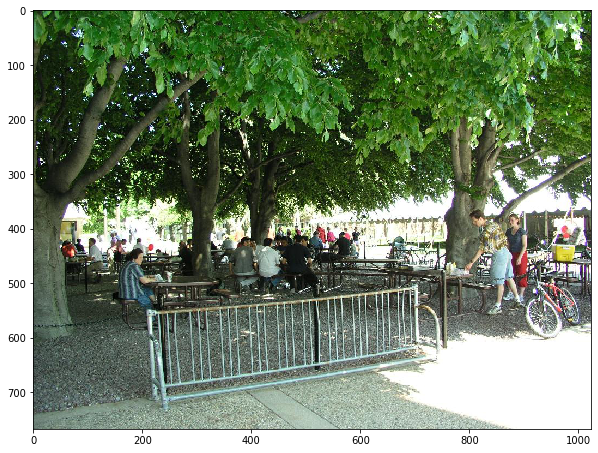

In [5]:
img_orig = Image.open('../data/i05june05_static_street_boston_p1010808.jpeg')

im_color_npy = np.asarray(img_orig)
N_X, N_Y, _ = im_color_npy.shape #dimensions 

ds= 1


fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(im_color_npy)

### Functions :
To create the cropped pyramid

In [6]:
def cropped_pyramid(img_tens, width=width, base_levels=base_levels, color=True, verbose=False):
    
    N_batch, _, N_X, N_Y = img_tens.shape # tensor of the images  (dimension 4)
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1 #computing the number of iterations cf:downsampling
    
    if color :
        img_crop = torch.zeros((N_batch, n_levels, 3, width, width))
        level_size=[[N_X, N_Y]]

    else :
        img_crop = torch.zeros((N_batch, n_levels, width, width)) #creating the tensor to store the cropped images while pyramiding
        
    img_down = img_tens.clone()
    for i_level in range(n_levels-1): #each iteration -> residual_image = image - downsampled_cloned_image_reshaped_to_the_right_size 
        img_residual = img_down.clone()
        img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode) #downsampling
        img_residual -= interpolate(img_down, size=img_residual.shape[-2:], mode=mode)  #upsizing in order to substract

        if verbose: print('Tensor shape=', img_down.shape, ', shape=', img_residual.shape)
        h_res, w_res = img_residual.shape[-2:] #at each iteration the residual image size is reduced of a factor 1/base_levels (img_down the image downsampled at the previous iteration)

        if color :
            img_crop[:, i_level, :, :, :] = img_residual[:, :, 
                            (h_res//2-width//2):(h_res//2+width//2), 
                            (w_res//2-width//2):(w_res//2+width//2)]
            level_size.append(list(img_down.shape[-2:]))
            
        else :
            img_crop[:, i_level, :, :] = img_residual[:, 0, 
                            (h_res//2-width//2):(h_res//2+width//2), 
                            (w_res//2-width//2):(w_res//2+width//2)] #the central crop of residual image stored in tensor img_crop
            level_size=0
            
    h_res, w_res = img_down.shape[-2:]
    
    if color :
        img_crop[:, n_levels-1, :, 
                 (width//2-h_res//2):(width//2+h_res//2), 
                 (width//2-w_res//2):(width//2+w_res//2)] = img_down #[0, :, :, :]
        
    else :
        img_crop[:, n_levels-1, 
             (width//2-h_res//2):(width//2+h_res//2), 
             (width//2-w_res//2):(width//2+w_res//2)] = img_down[:, 0, :, :]
    if verbose: print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels) #print image's dimensions after downsampling, condition max(img_down.shape[-2:])<=width satisfied
    return img_crop, level_size

### Inversing the pyramid from the coefficients
Once the pyramid is done we can create the reconstructed image.

In [7]:
def inverse_pyramid(img_crop, N_X=N_X, N_Y=N_Y, base_levels=base_levels, verbose=False):
    N_batch = img_crop.shape[0] 
    width = img_crop.shape[3] 
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1 #number of cropped images = levels of the pyramid
    
    img_rec = img_crop[:, -1, :, :, :] #.unsqueeze(1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode) #upsampling (factor=base_levels)
        h_res, w_res = img_rec.shape[-2:]
        img_rec[:, :, 
                (h_res//2-width//2):(h_res//2+width//2), 
                (w_res//2-width//2):(w_res//2+width//2)] += img_crop[:, i_level, :, :, :] #adding previous central crop to img_crop 
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

Using the roll function to create images centered on the successive focal points :

https://numpy.org/doc/stable/reference/generated/numpy.roll.html

In [8]:
def saccade_to(img_color, orig, loc_data_ij): 
    img_copy = np.copy(img_color)
    img_copy=np.roll(img_copy, orig[0] - loc_data_ij[0], axis=0)
    img_copy=np.roll(img_copy, orig[1] - loc_data_ij[1], axis=1)
    return img_copy 

In [9]:
def tens_saccade_to(img_color_tens, orig, loc_data_ij): 
    img_copy = torch.clone(img_color_tens)
    img_copy = torch.roll(img_copy, (orig[0] - loc_data_ij[0],), (2,))
    img_copy = torch.roll(img_copy, (orig[1] - loc_data_ij[1],), (3,))
    return img_copy 

Constructing the levels

In [10]:
def level_construct(img_crop_list, loc_data_ij, level_size, level):
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    orig = level_size[0]//2, level_size[1]//2
    img_lev = torch.zeros((1, 3, level_size[0], level_size[1]))
    img_div = torch.zeros((1, 3, level_size[0], level_size[1]))
    #print(img_lev.shape)
    nb_saccades = len(img_crop_list)
    for num_saccade in range(nb_saccades):
        sac_img =  img_crop_list[num_saccade][:, level, :, :, :]
        if level_size[0] < width:
            x_width = level_size[0]
            sac_img = sac_img[:,:,width//2 - level_size[0]//2:width//2 + level_size[0]//2,:]
        else:
            x_width = width  
        if level_size[1] < width:
            y_width = level_size[1]
            sac_img = sac_img[:,:,:,width//2 - level_size[1]//2:width//2 + level_size[1]//2]  
        else:
            y_width = width
        #print(sac_img.shape)
            
        loc = loc_data_ij[num_saccade] // 2**level
        img_lev = tens_saccade_to(img_lev, orig, loc)
        img_lev[:,:,orig[0]-x_width//2:orig[0]+x_width//2, orig[1]-y_width//2:orig[1]+y_width//2] += sac_img 
        img_lev = tens_saccade_to(img_lev, loc, orig)
        img_div = tens_saccade_to(img_div, orig, loc)
        img_div[:,:,orig[0]-x_width//2:orig[0]+x_width//2, orig[1]-y_width//2:orig[1]+y_width//2] += torch.ones_like(sac_img) 
        img_div = tens_saccade_to(img_div, loc, orig)
    # coefficients normalization    
    indices_zero = (img_div == 0).nonzero().detach().numpy()
    img_div_npy = img_div.detach().numpy()
    for ind in indices_zero:
        img_div_npy[ind[0], ind[1], ind[2], ind[3]] = 1
    img_lev = img_lev // img_div_npy
    plt.figure()
    if level < n_levels-1:
        bias = 128
    else:
        bias = 0
    img_aff = img_lev.detach().permute(0,2,3,1)[0,:,:,:].numpy()
    plt.imshow((img_aff+bias).astype('uint8'))
    return img_lev
    

Inversing the pyramid when adding saccades

In [11]:
def inverse_pyramid_saccades(img_crop_list, loc_data_ij, level_size, N_X=N_X, N_Y=N_Y, base_levels=base_levels, verbose=False):
    N_batch = img_crop.shape[0] 
    width = img_crop.shape[3] 
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    
    #img_rec = img_crop[:, -1, :, :, :] #.unsqueeze(1)
    img_rec = level_construct(img_crop_list, loc_data_ij, level_size[n_levels-1], level=n_levels-1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode) #upsampling (factor=base_levels)
        h_res, w_res = img_rec.shape[-2:]
        img_lev = level_construct(img_crop_list, loc_data_ij, level_size[i_level], level=i_level)
        img_rec += img_lev #adding previous central crop to img_crop 
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

### Log gabor functions :
Creating the filters

In [12]:
from LogGabor import LogGabor
pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.6, 'B_theta': np.pi/12 ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}                 #log-Gabor parameters
lg = LogGabor(pe)
print('lg shape=', lg.pe.N_X, lg.pe.N_Y)

lg shape= 32 32


In [13]:
def local_filter(azimuth, theta, phase, sf_0=.25, B_theta=lg.pe.B_theta, radius=width/4):

    x, y = lg.pe.N_X//2, lg.pe.N_Y//2         # center
    x += radius * np.cos(azimuth)
    y += radius * np.sin(azimuth)
    
    return lg.normalize(lg.invert(
        lg.loggabor(x, y, sf_0=sf_0, B_sf=lg.pe.B_sf, theta=theta, B_theta=B_theta) * np.exp(-1j * phase)))

K = local_filter(azimuth=0, theta=0, phase=0, radius=width/4) 
print('K shape=', K.shape)
print('K min max=', K.min(), K.max())

K shape= (32, 32)
K min max= -0.41029997089061887 1.0


Creating the set K :

In [14]:
def get_K(width=width, n_sublevel = n_sublevel, n_azimuth = n_azimuth, n_theta = n_theta, 
          n_phase = n_phase, r_min = width/6, r_max = width/3, log_density_ratio = 2, verbose=False): #filter tensor K definition using Di Carlo's formulas
    K = np.zeros((width, width, n_sublevel, n_azimuth, n_theta, n_phase))
    for i_sublevel in range(n_sublevel):
        sf_0 = .25*(np.sqrt(2)**i_sublevel)
        
        #radius = width/4/(np.sqrt(2)**i_sublevel)
        # Di Carlo / Retina Warp
        
        b = np.log(log_density_ratio)  / (r_max - r_min)
        a = (r_max - r_min) / (np.exp (b * (r_max - r_min)) - 1)
        r_ref = r_min + i_sublevel * (r_max - r_min) / n_sublevel
        r_prim =  a * np.exp(b * (r_ref - r_min))
        radius =  r_prim
        d_r_prim = a * b * np.exp(b * (r_ref - r_min))
        p_ref = 4 * width / 32 
        p_loc = p_ref * d_r_prim
        sf_0 = 1 / p_loc
        if verbose: print('i_sublevel, sf_0, radius', i_sublevel, sf_0, radius)
        for i_azimuth in range(n_azimuth):
            for i_theta in range(n_theta):
                for i_phase in range(n_phase):
                    azimuth = (i_azimuth+i_sublevel/2)*2*np.pi/n_azimuth
                    K[..., i_sublevel, i_azimuth, i_theta, i_phase] = local_filter(azimuth=azimuth,
                                                                                   theta=i_theta*np.pi/n_theta + azimuth, 
                                                                                   phase=i_phase*np.pi/n_phase, sf_0=sf_0, radius=radius)
    K = torch.Tensor(K)

    if verbose: print('K shape=', K.shape)
    if verbose: print('K min max=', K.min(), K.max())

    return K

i_sublevel, sf_0, radius 0 0.3606737602222408 5.333333333333333
i_sublevel, sf_0, radius 1 0.2550348616491973 7.542472332656507
K shape= torch.Size([32, 32, 2, 12, 12, 2])
K min max= tensor(-1.) tensor(1.)


In [15]:
def inverse_pyramid_gabor(out, K, N_X=N_X, N_Y=N_Y, base_levels=base_levels, verbose=False):
    N_batch = out.shape[0] 
    width =  K.shape[0]
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    n_sublevel, n_azimuth, n_theta, n_phase = K.shape[2:]
    
    out__ = out.reshape((N_batch, n_levels, n_sublevel*n_azimuth*n_theta*n_phase))
    K_ = K.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
    K_inv = torch.pinverse(K_)
    img_crop_rec =  torch.tensordot(out__, K_inv,  dims=1).reshape((N_batch, n_levels, width, width))

    img_rec = img_crop_rec[:, -1, :, :].unsqueeze(1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode) #upsampling (factor=base_levels)
        h_res, w_res = img_rec.shape[-2:]
        img_rec[:, 0, (h_res//2-width//2):(h_res//2+width//2), (w_res//2-width//2):(w_res//2+width//2)] += img_crop_rec[:, i_level, :, :] #adding previous central crop to img_crop 
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

### 1.3. Converting to a tensor format
In order to interpolate and build the pyramid we need to work with tensors : the image is converted using the module Pytorch.

In [16]:
img_tens = torch.Tensor(im_color_npy[None, ...]) 
img_tens = img_tens.permute(0,3,1,2)
print('Tensor shape=', img_tens.shape) #image's size stored in img_tens.shape[-2:] 

Tensor shape= torch.Size([1, 3, 768, 1024])


### 1.4. Using torch to build up a Laplacian pyramid


https://www.cs.tau.ac.il/~dcor/Graphics/Exercises/burt83laplacian.pdf


To build the pyramid we down-sample recursively, until the image's size is 32*32.

The scale factor is 1/2 : for each iteration the image size is reduced by half.
https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.interpolate

In [17]:
from torch.nn.functional import interpolate 

torch.Size([384, 512, 3])


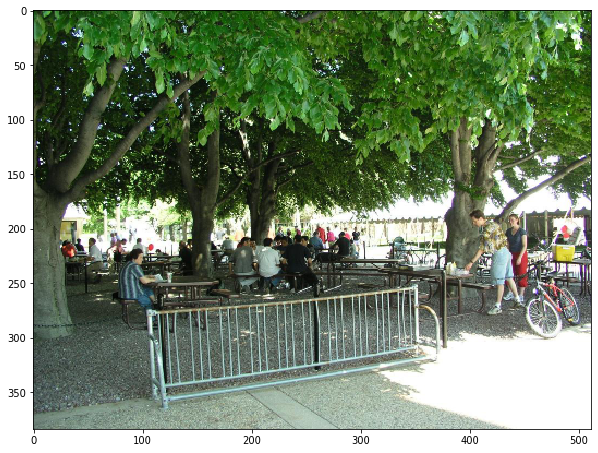

In [18]:
img_down = interpolate(img_tens, scale_factor=1/2, mode=mode) #interpolating
img_aff = img_down.permute(0,2,3,1)[0,:,:,:] # Permuting the tensors dimensions to deal with color 
print(img_aff.shape)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_aff.numpy().astype('uint'))
#ax.plot(N_Y//2, N_X//2, 'r+', ms=32);

In [19]:
img_down = img_tens.clone() 
n_levels = 0
while max(img_down.shape[-2:]) > width : # until obtaining sides inferior to width (cf cropped image at each step) 
    n_levels += 1 
    print('Tensor shape=', img_down.shape, ', n_levels=', n_levels) #each iteration reduces the image's size by a factor defined by base_levels
    #print(np.log(img_down.shape[-2:])/np.log(base_levels)-np.log(width)/np.log(base_levels))
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode) # downsampling 1/base_levels (bilinear mode)
n_levels += 1
print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)

Tensor shape= torch.Size([1, 3, 768, 1024]) , n_levels= 1
Tensor shape= torch.Size([1, 3, 384, 512]) , n_levels= 2
Tensor shape= torch.Size([1, 3, 192, 256]) , n_levels= 3
Tensor shape= torch.Size([1, 3, 96, 128]) , n_levels= 4
Tensor shape= torch.Size([1, 3, 48, 64]) , n_levels= 5
Top tensor shape= torch.Size([1, 3, 24, 32]) , Final n_levels= 6


#### Applying on the central crop of $32\times32$:

Creating the pyramid by calling the function

In [20]:
img_crop = cropped_pyramid(img_tens, color=True, verbose=False)[0]

Displaying central crops from successive residual images

Tensor shape= torch.Size([1, 6, 3, 32, 32])


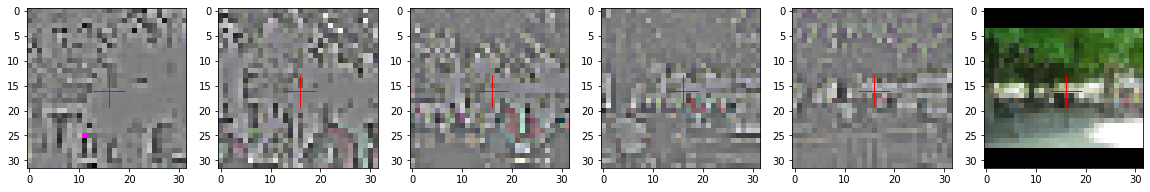

In [21]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
img_aff = img_crop.permute(0,1,3,4,2).numpy()
for i_level, ax in enumerate(axs):
    if i_level < n_levels-1:
        bias = 128
    else:
        bias = 0
    ax.imshow((img_aff[0, i_level, ...]+bias).astype('uint8'))
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)  

### 1.5. Reconstruction
#### Inversing the pyramid using the function

In [22]:
img_rec = inverse_pyramid(img_crop)

#### Plotting reconstructed image

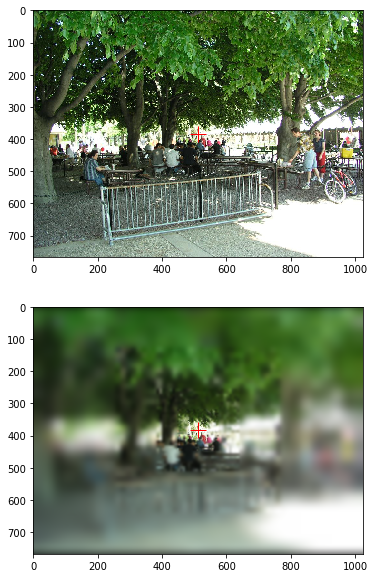

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
for ax, img in zip(axs, [img_tens, img_rec.detach()]):
    img = img.permute(0,2,3,1)[0,:,:,:]
    ax.imshow(img.numpy().astype('uint8'))
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

## 2. Adding the saccades
For this image we have an array containing the different points of interest covered by an eye using saccades.

In [24]:
name = 'i05june05_static_street_boston_p1010808'
impath = '../data/'+name+'.jpeg'
locpath = '../data/'+name+'.pkl'

### 2.1. Sliding gaze 
First we "roll" the image to place the point of interest in the center, as though the eye was moving. This way the image keeps the same dimension.

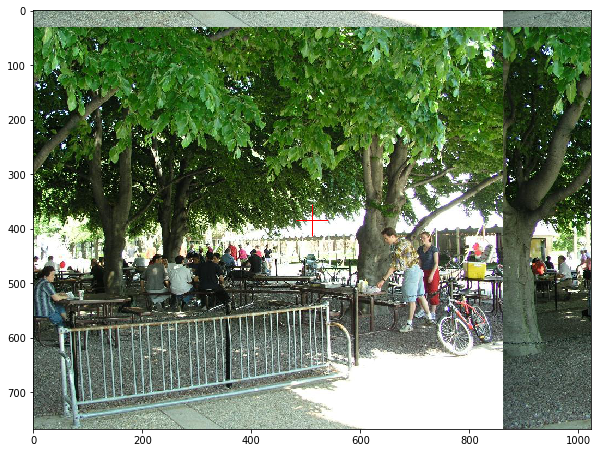

In [25]:
im_color_npy = np.roll(im_color_npy, -162//ds, axis=1) # sliding gaze to the right by moving image to the left
im_color_npy = np.roll(im_color_npy, 32//ds, axis=0) # sliding gaze to the top by moving image to the bottom


fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(im_color_npy)
ax.plot(N_Y//2, N_X//2, 'r+', ms=32);

In [26]:
import pickle
f = open(locpath,'rb')
loc_dict = pickle.load(f) # coordinates of the points of interest
loc_dict

{'image_name': 'i05june05_static_street_boston_p1010808',
 'barycenters': [(498, 384),
  (192, 425),
  (857, 437),
  (949, 513),
  (585, 546),
  (486, 288),
  (648, 415)]}

### 2.2. Saccade path

Converting to a tensor format

In [27]:
im_color_npy = np.asarray(img_orig)
img_tens = torch.Tensor(im_color_npy[None, ...]) 
img_tens = img_tens.permute(0,3,1,2)             #image's size stored in img_tens.shape[-2:]
print('Tensor shape=', img_tens.shape) 

Tensor shape= torch.Size([1, 3, 768, 1024])


In [28]:
loc_data_xy = np.array(loc_dict['barycenters'])
loc_data_ij = []
for coord in loc_data_xy:
    loc_data_ij += [[coord[1], coord[0]]]
loc_data_ij = np.array(loc_data_ij)
#print(loc_data_xy)
#print(loc_data_ij)

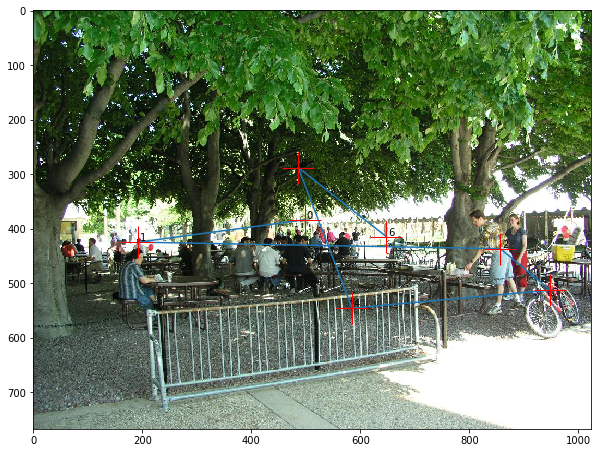

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(im_color_npy, cmap='gray')

ax.plot(loc_data_xy[:,0], loc_data_xy[:,1])
for i, coord in enumerate(loc_data_xy):
    ax.plot(coord[0], coord[1], 'r+', ms=32)
    ax.text(coord[0]+3, coord[1]-3, i)

In [30]:
orig = np.zeros(2, dtype='int')
orig[0] = N_X//2
orig[1] = N_Y//2
print("Coordinates of the center : ", orig) 

Coordinates of the center :  [384 512]


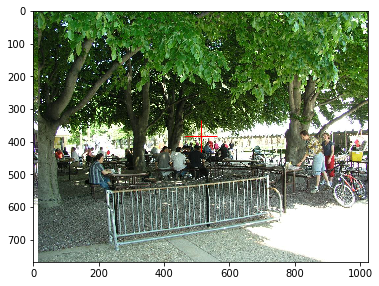

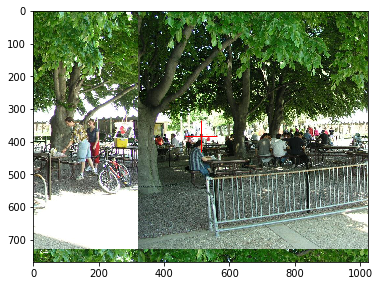

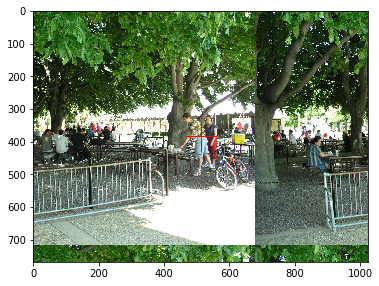

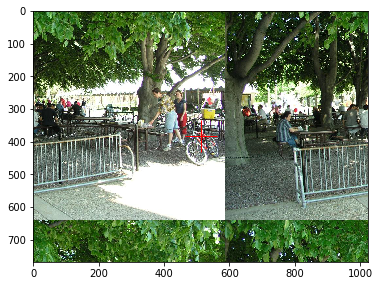

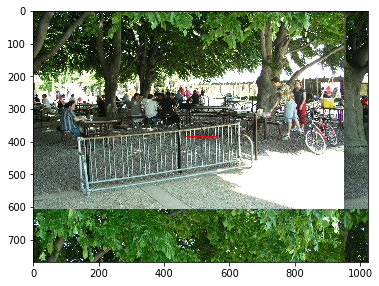

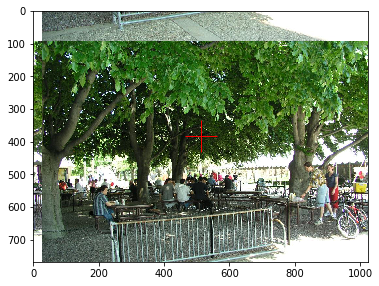

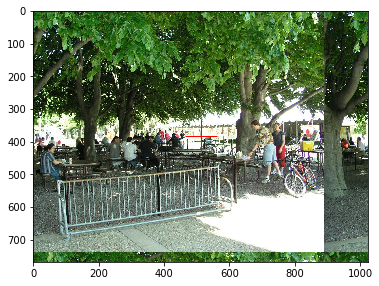

In [31]:
img_color_roll=[]
for i in range(len(loc_data_ij)):
    plt.figure(figsize=(6,6))
    #plt.imshow(img_color_roll[i])
    im_color_sac = saccade_to(im_color_npy, (N_X//2, N_Y//2), loc_data_ij[i])
    plt.imshow(im_color_sac)
    plt.plot(orig[1], orig[0], 'r+', ms=32)
    img_color_roll.append(im_color_sac)

In [32]:
#Computing number of iterations to downsample the image to a size < width
n_levels = int(np.log(np.max(im_color_npy.shape)/width)/np.log(base_levels)) + 1 
print('Computed n_levels=', n_levels)

Computed n_levels= 6


In [33]:
#N_batch, _, N_X, N_Y = img_tens.shape
#level_size = [[768, 1024], [384, 512], [192, 256], [96, 128], [48, 64], [24, 32]]
#print(level_size)

In [34]:
img_color_pyr_tens=[]
for i in range(len(loc_data_ij)):
    img_tens = torch.Tensor(img_color_roll[i][None, ...]) 
    img_tens = img_tens.permute(0,3,1,2)
    img_crop, level_size = cropped_pyramid(img_tens, verbose=False)
    img_color_pyr_tens.append(img_crop)
print(level_size)

[[768, 1024], [384, 512], [192, 256], [96, 128], [48, 64], [24, 32]]


In [35]:
img_rec = inverse_pyramid(img_crop)

Plotting reconstructed image :

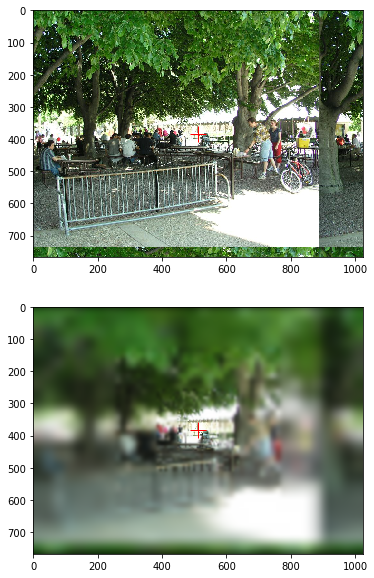

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
for ax, img in zip(axs, [img_tens, img_rec.detach()]):
    img = img.permute(0,2,3,1)[0,:,:,:]
    ax.imshow(img.numpy().astype('uint8'))
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

### 2.3 Reconstruction from multiple saccades

Creating all the images rolled according to saccade data, and using the Laplacian pyramid.

In [37]:
img_color_pyr_rec=[]
for i in range(len(loc_data_ij)):
    img_color_pyr_rec.append(inverse_pyramid(img_color_pyr_tens[i], verbose=True))
 

torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])


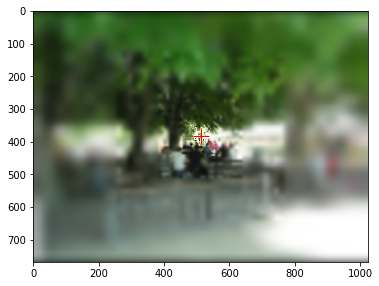

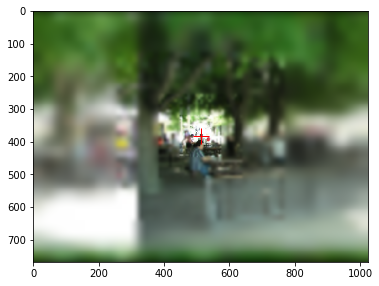

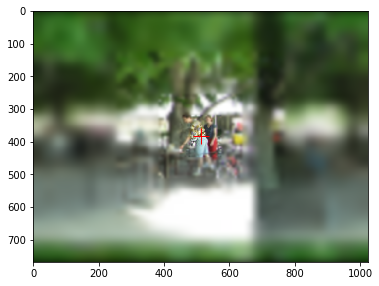

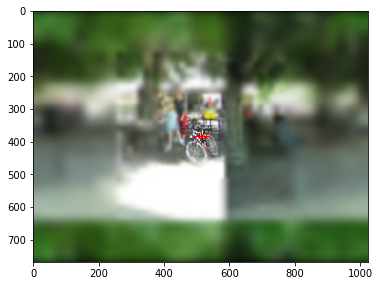

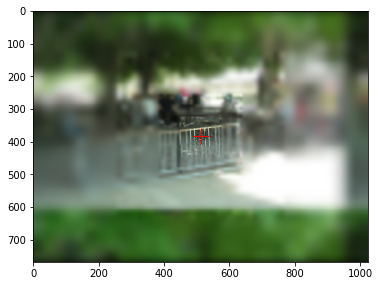

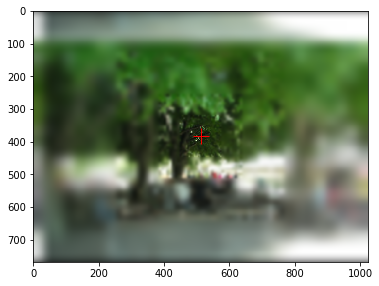

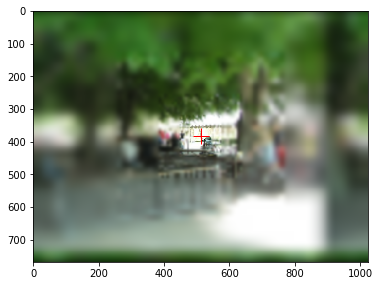

In [38]:
for i, img in enumerate(img_color_pyr_rec):
    plt.figure(figsize=(6,6))
    img_color_pyr_npy = img_color_pyr_rec[i].detach()  
    print(img_color_pyr_npy.shape)
    img_color_pyr_npy = img_color_pyr_npy.permute(0,2,3,1)[0,:,:,:]
    plt.imshow(img_color_pyr_npy.numpy().astype('uint8'))
    plt.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

In [39]:
loc_data_ij[0] // 2**5

array([12, 15], dtype=int32)

The cropped images are layed on a blank image of the original image dimensions. 

On this array we can reconstruct the visual field, the eye travels the scene using saccades.

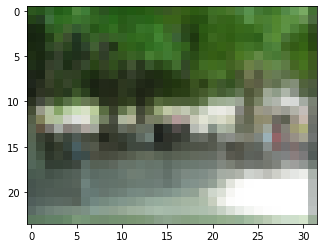

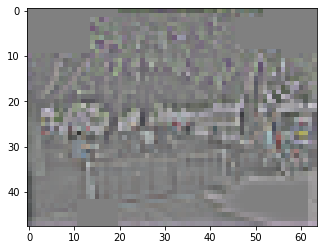

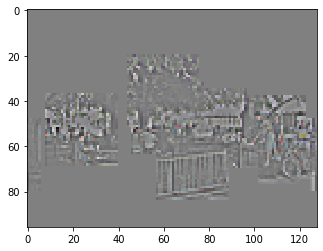

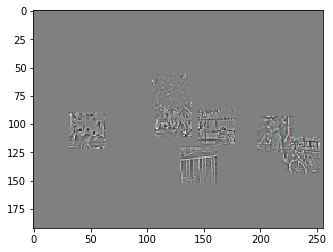

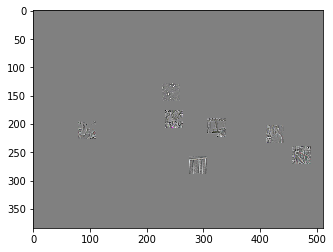

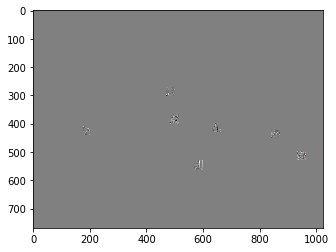

In [40]:
img_sac = inverse_pyramid_saccades(img_color_pyr_tens, loc_data_ij, level_size, verbose=True)

## 3. Reconstructing the visual field
Using the multiple saccades and the pyramid only, the visual result is in color, and better than when using log-gabor filters. 
However, the 32*32 squares are visible (overlapped cropped images, not continuous), and further from the eye's biological functionning.

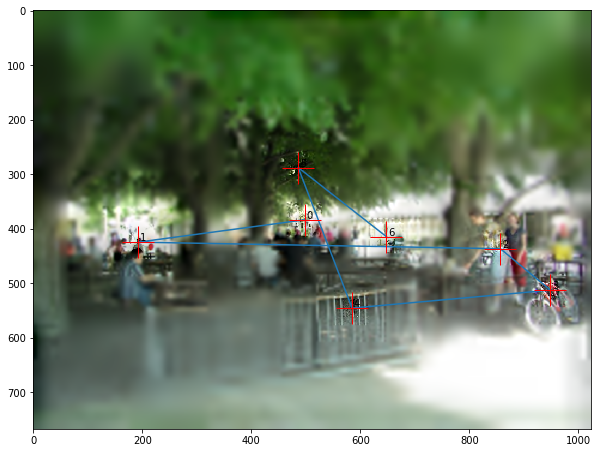

In [41]:
plt.figure(figsize=(10,10))
im = img_sac.detach().permute(0,2,3,1)[0,:,:,:].numpy()
im = np.clip(im,0,255).astype('uint8')

plt.imshow(im)
plt.plot(loc_data_ij[:,1], loc_data_ij[:,0])
for i, coord in enumerate(loc_dict['barycenters']):
    plt.plot(coord[0], coord[1], 'r+', ms=32)
    plt.text(coord[0]+3, coord[1]-3, i)

## 4. Log-Gabor filters
### 4.1. Loading an image

In [42]:
%ls ../data #list of images stored in file data
img_orig = imread('../data/i05june05_static_street_boston_p1010764.jpeg')
ds = 1
if ds>1: img_orig = img_orig[::ds, ::ds]
img_orig = np.roll(img_orig, -162//ds, axis=1) # sliding gaze to the right by moving image to the left
img_orig = np.roll(img_orig, 32//ds, axis=0) # sliding gaze to the top by moving image to the bottom

N_X, N_Y = img_orig.shape
pe = {'N_X': N_X, 'N_Y': N_Y, 'do_mask': True} 

im = Image(pe) 
img_orig -= img_orig.mean() #substracting the image's mean to each element
img_orig *= im.mask #adding an oval mask  
img_tens = torch.Tensor(img_orig[None, None, ...]) 
print('Tensor shape=', img_tens.shape) #converting to a tensor format, image's size stored in img_tens.shape[-2:]

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img_orig, cmap='gray')
ax.plot([img_orig.shape[1]/2], [img_orig.shape[0]/2], 'r+', ms=32);

Le format du paramŠtre est incorrect - "data".


TypeError: 'module' object is not callable

### 4.2. Using torch to build up a Laplacian pyramid

In [43]:
from torch.nn.functional import interpolate 

In [44]:
img_down = img_tens 
n_levels = 0
while max(img_down.shape[-2:]) > width : # until obtaining sides inferior to width (cf cropped image at each step) 
    n_levels += 1 
    #print('Tensor shape=', img_down.shape, ', n_levels=', n_levels) #each iteration reduces the image's size by a factor defined by base_levels
    #print(np.log(img_down.shape[-2:])/np.log(base_levels)-np.log(width)/np.log(base_levels))
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode) # downsampling 1/base_levels (bilinear mode)
n_levels += 1
#print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)

#Computing number of iterations to downsample the image to a size < width
n_levels = int(np.log(np.max(img_orig.shape)/width)/np.log(base_levels)) + 1 
print('Computed n_levels=', n_levels)

Computed n_levels= 6


Applying on the central crop of $32\times32$:

In [45]:
img_tens = torch.Tensor(img_orig[None, None, ...])
img_crop = cropped_pyramid(img_tens, color=False, verbose=True)[0]

Tensor shape= torch.Size([1, 1, 384, 512]) , shape= torch.Size([1, 1, 768, 1024])
Tensor shape= torch.Size([1, 1, 192, 256]) , shape= torch.Size([1, 1, 384, 512])
Tensor shape= torch.Size([1, 1, 96, 128]) , shape= torch.Size([1, 1, 192, 256])
Tensor shape= torch.Size([1, 1, 48, 64]) , shape= torch.Size([1, 1, 96, 128])
Tensor shape= torch.Size([1, 1, 24, 32]) , shape= torch.Size([1, 1, 48, 64])
Top tensor shape= torch.Size([1, 1, 24, 32]) , Final n_levels= 6


Displaying central crops from successive residual images

Tensor shape= torch.Size([1, 6, 32, 32])


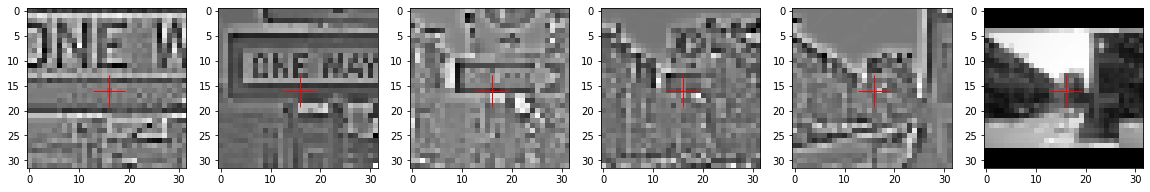

In [46]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)  

### 4.3. Creating a set of filters

Log-Gabor filters:

documentation = https://nbviewer.jupyter.org/github/bicv/LogGabor/blob/master/LogGabor.ipynb
![Log-Gabor filters](https://camo.githubusercontent.com/867ab3c53cbeda20615518c722c60ec9071ee002/68747470733a2f2f6c617572656e7470657272696e65742e6769746875622e696f2f7075626c69636174696f6e2f666973636865722d30372d63762f66656174757265642e706e67)

In [ ]:
K = get_K(verbose=True)

### 4.4. Applying the filters to the cropped images

In [47]:
print('Tensor shape=', img_crop.shape) #cropped image tensor shape

out = torch.tensordot(img_crop, K,  dims=2) # applying K filters to the cropped image (convolution)

print('Tensor shape=', out.shape)

Tensor shape= torch.Size([1, 6, 32, 32])
Tensor shape= torch.Size([1, 6, 2, 12, 12, 2])


Reconstruction layer by layer from cropped central images:

Tensor shape= torch.Size([1, 6, 32, 32])


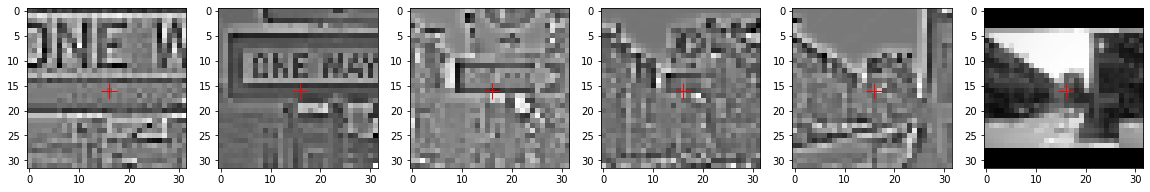

In [48]:
#displaying central crops from successive residual images (cf pyramid)
fig, axs = plt.subplots(1, n_levels, figsize=(20,20)) 
for i_level, ax in enumerate(axs):
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=16);
print('Tensor shape=', img_crop.shape)  

In [58]:
print('Filter tensor shape=', K.shape) 
K_ = K.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
print('Reshaped filter tensor=', K_.shape)

print('Tensor shape=', out.shape) #cropped image tensor shape after the convolution
tra
print('Tensor shape=', out__.shape)

Filter tensor shape= torch.Size([32, 32, 2, 12, 12, 2])
Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([1, 6, 2, 12, 12, 2])
Tensor shape= torch.Size([1, 6, 576])


Inversing K filters

In [50]:
K_inv = torch.pinverse(K_) 
print('Tensor shape=', K_inv.shape)

img_rec =  torch.tensordot(out__, K_inv,  dims=1).reshape((1, n_levels, width, width)) 
print('Tensor shape=', img_rec.shape)

Tensor shape= torch.Size([576, 1024])
Tensor shape= torch.Size([1, 6, 32, 32])


In [51]:
img_rec =  torch.tensordot(out__, K_inv,  dims=1).reshape((1, n_levels, width, width)) 
print('Tensor shape=', img_rec.shape)

Tensor shape= torch.Size([1, 6, 32, 32])


Tensor shape= torch.Size([1, 6, 32, 32])


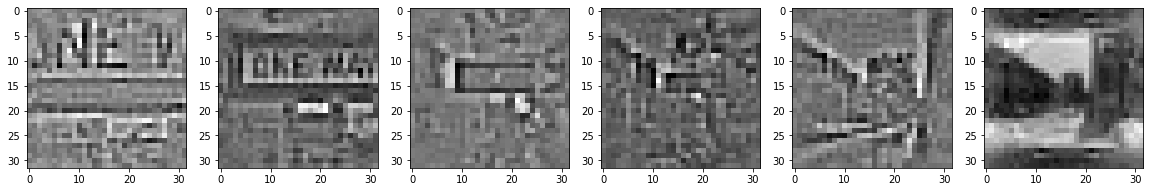

In [52]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20)) #reconstructing cropped images from the pyramid
for i_level, ax in enumerate(axs):
    ax.imshow(img_rec.numpy()[0, i_level, ...], cmap='gray')
print('Tensor shape=', img_crop.shape)

### 4.5. Inverse pyramid from the coefficients

In [53]:
img_rec = inverse_pyramid_gabor(out, K)

#### Plotting reconstructed image

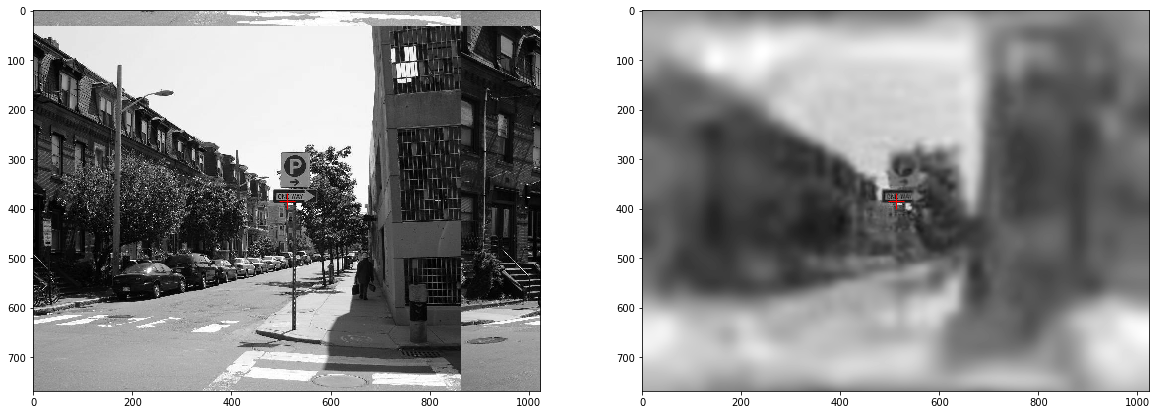

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(20,20))
for ax, img in zip(axs, [img_tens, img_rec.detach()]):
    ax.imshow(img[0, 0, :, :].numpy(), cmap='gray')
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

In [55]:
def inverse_pyramid_gabor(out, K, N_X=N_X, N_Y=N_Y, base_levels=base_levels, verbose=False):
    N_batch = out.shape[0] 
    width =  K.shape[0]
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    n_sublevel, n_azimuth, n_theta, n_phase = K.shape[2:]
    
    out__ = out.reshape((N_batch, n_levels, n_sublevel*n_azimuth*n_theta*n_phase))
    K_ = K.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
    K_inv = torch.pinverse(K_)
    img_crop_rec =  torch.tensordot(out__, K_inv,  dims=1).reshape((N_batch, n_levels, width, width))

    img_rec = img_crop_rec[:, -1, :, :].unsqueeze(1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode) #upsampling (factor=base_levels)
        h_res, w_res = img_rec.shape[-2:]
        img_rec[:, 0, (h_res//2-width//2):(h_res//2+width//2), (w_res//2-width//2):(w_res//2+width//2)] += img_crop_rec[:, i_level, :, :] #adding previous central crop to img_crop 
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

In [59]:
def inverse_pyramid(img_crop, N_X=N_X, N_Y=N_Y, base_levels=base_levels, verbose=False):
    N_batch = img_crop.shape[0] 
    width = img_crop.shape[3] 
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1 #number of cropped images = levels of the pyramid
    
    img_rec = img_crop[:, -1, :, :, :] #.unsqueeze(1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode) #upsampling (factor=base_levels)
        h_res, w_res = img_rec.shape[-2:]
        img_rec[:, :, 
                (h_res//2-width//2):(h_res//2+width//2), 
                (w_res//2-width//2):(w_res//2+width//2)] += img_crop[:, i_level, :, :, :] #adding previous central crop to img_crop 
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

In [61]:
def inverse_log_polar(img_feat, K):
    width =  K.shape[0]
    n_sublevel, n_azimuth, n_theta, n_phase = K.shape[2:]
    out__ = out.reshape((N_batch, n_levels, n_sublevel*n_azimuth*n_theta*n_phase))
    K_ = K.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
    K_inv = torch.pinverse(K_)
    img_crop_rec =  torch.tensordot(out__, K_inv,  dims=1).reshape((N_batch, n_levels, width, width))

    return img_crop_rec